## Хомутов Евгений Васильевич, МСКМ-191
# Вычислительная геномика

In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика.

В качестве начального распределения возьмем предельное распределение. Решая систему уравнений и нормировочное уравнение:
$$
0.95p_1+ 0.05p_2 = p_1
$$
$$
0.01p_1+ 0.9p_2 = p_2
$$
$$
p_1 + p_2 = 1 
$$
получаем, что искомые вероятности равны (2/3;1/3)

In [2]:
class Croupier():
    def __init__(self):
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': [0.95,0.05], # to F, to U
            'U': [0.1,0.9] # to F, to U
        }
        
        self.startProbability = [2/3,1/3]

        self.currentState = np.random.choice(self.states, p =self.startProbability)
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }


    def changeDice(self):
        self.currentState = np.random.choice(self.states,p=self.transitionsProbability[self.currentState])

    def roll(self):
        return np.random.choice(self.diceValues, p=self.diceValueProbability[self.currentState]), self.currentState

    def __call__(self):
        self.changeDice()
        return self.roll()

In [3]:
casino = Croupier()
for i in range(10):
    print(casino())

(2, 'F')
(4, 'F')
(4, 'F')
(6, 'U')
(1, 'U')
(5, 'U')
(6, 'F')
(3, 'F')
(2, 'F')
(3, 'F')


Сгенерируем датасеты размером 300, 1 000 и 10 000

In [4]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

In [5]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

In [6]:
dataset10000 = []
dataset10000Labels = []

casino = Croupier()

for i in range(10000):
    data, label = casino()
    dataset10000.append(data)
    dataset10000Labels.append(label)

Ноль соответсвует честной кости, единица - нечестной.

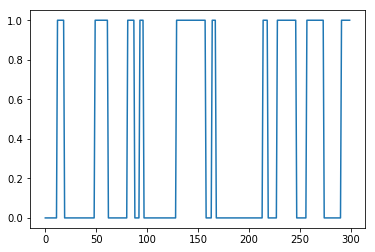

In [7]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

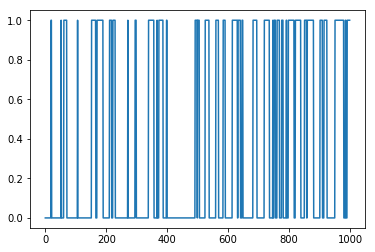

In [8]:
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
plt.plot(lab1000)

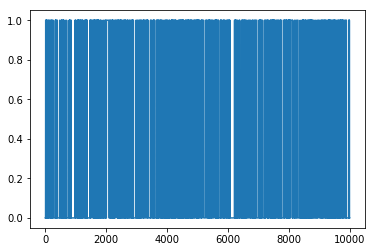

In [9]:
lab10000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
plt.plot(lab10000)

Посчитаем количество раз, когда использоволась какая кость для 10 000 раз

In [10]:
from collections import Counter
Counter(dataset10000Labels)

Counter({'F': 6420, 'U': 3580})

Все хорошо согласуется с предельным распределением, следовательно сплошная линия на графике для 10 000 ошибка изображения, но не моделирования

Определим базовый класс для алгоритмов, в котором будем хранить данные о нашей скрытой марковской цепи

In [11]:
class baseAlgo():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

## Алгоритм Витерби

Реализуем алгоритм Витерби

In [12]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

RESULT: 0.78
Probability: 2.239213574741771e-235


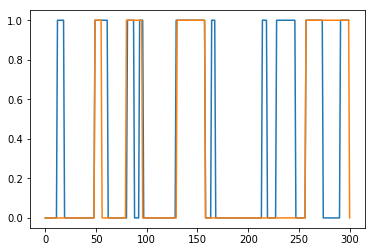

In [13]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.677
Probability: 0.0


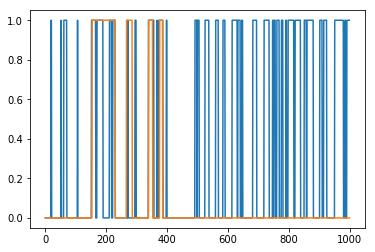

In [14]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

RESULT: 0.6465
Probability: 0.0


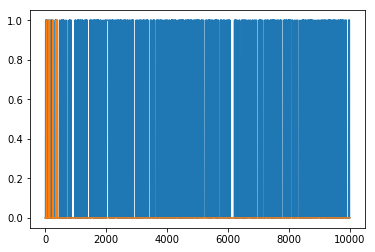

In [15]:
hackCasinoViterbi = algorithmViterbi(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

Из графиков икачетсва работы с 1000 и 10 000 экземпляров видно, что накапление машинной ошибки ведет к тому, что алгоритм уже не в состояние выдавать ненулевые значения. Чтобы избежать этого, перейдем в логарифмический масштаб

In [16]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [17]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.78
Probability: 2.2392135747408677e-235


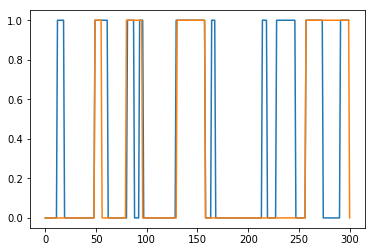

In [18]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.765
Probability: 2.2392135747408677e-235


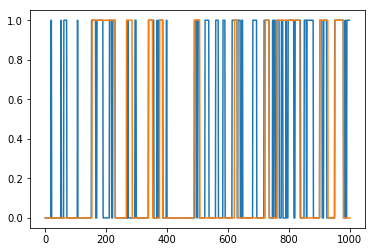

In [19]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.795
Probability: 2.2392135747408677e-235


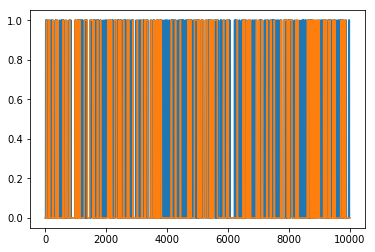

In [20]:
hackCasinoViterbi = algorithmViterbiLog(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab10000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

Использование логарифмического масштаба улучшило работы алгоритма, что видно как гарфически так и численно, в сравнение с правильными лейблами для костей.

## Алгорит прямого и обратного хода, апостериорное дешифрование

In [21]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.f = []
        self.pathProbability = None
    
    def step(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.step(i)
        self.pathProbability = sum(self.f[-1])

In [22]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        self.b = []
        self.pathProbability = None
    
    def step(self, index):
        self.b.append([])
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,0,-1):
            self.step(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbability = sum(self.b[0])

In [23]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\n'.format(f,b))

FORWARD: 1.6488925933822808e-226
BACKWARD: 1.8407532906902136e-225



Проведем проверку

In [24]:
pprint.pprint([sum(f*np.array(b)) for f, b in zip(forwardHack.f, backwardHack.b)])

[1.648892593382299e-226,
 1.6488925933822986e-226,
 1.6488925933822986e-226,
 1.6488925933822984e-226,
 1.6488925933822982e-226,
 1.648892593382298e-226,
 1.648892593382298e-226,
 1.648892593382298e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.6488925933822979e-226,
 1.648892593382298e-226,
 1.6488925933822982e-226,
 1.6488925933822982e-226,
 1.6488925933822982e-226,
 1.6488925933822984e-226,
 1.648892593382298e-226,
 1.648892593382298e-226,
 1.6488925933822979e-226,
 1.6488925933822977e-226,
 1.6488925933822977e-226,
 1.6488925933822979e-226,
 1.6488925933822975e-226,
 1.6488925933822975e-226,
 1.6488925933822973e-226,
 1.6488925933822971e-226,
 1.6488925933822971e-226,
 1.648892593382297e-226,
 1.648892593382297e-226,
 1.6488925933822967e-226,
 1.6488925933822965e-

Так как на каждом шаге у нас выдается одна и таже велечина, то прямой и обратный ход рабоатют корректно

In [25]:
class PosteriorDecoding(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i, state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackward(self, index):
        ### backward step
        self.bCurrent = []
        self.b.append([])
        nextState = self.b[-2]
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        self.bPrevious = [1,1]
        
        self.b.append([1 for state in self.states])
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

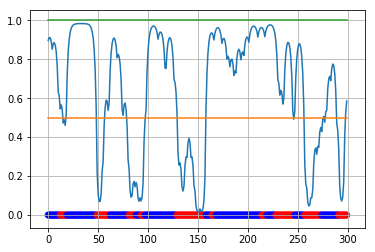

In [74]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


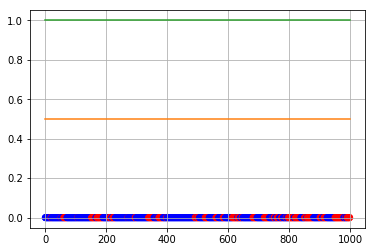

In [27]:
PosteriorHack = PosteriorDecoding(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


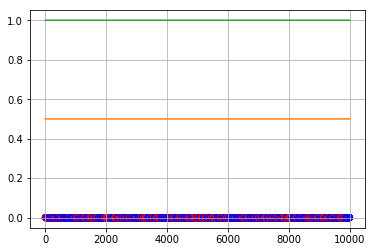

In [28]:
PosteriorHack = PosteriorDecoding(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Из-за потери машиной точности, графики на последовательностях 1000 и 10 000 построить не получилось. Чтобы исправить эту проблему применим масштабирование для алгоритма декодирования

In [29]:
def multiply(n):
    """
    Вспомогательная функция, которая перемножает элементы массива
    """
    total = 1
    for i in n: total *= i
    return total

In [197]:
class PosteriorDecodingScaled(baseAlgo):
    def __init__(self, data):
        baseAlgo.__init__(self, data)
        
        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        # For scaling
        self.scaledConstF = []
        self.scaledConstB = []
        
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i, state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
    
    def stepBackward(self, index):
        ### backward step
        self.b.append([])
        nextState = self.b[-2]
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
        
        self.scaledConstB.append(max(self.b[-1]))
        self.b[-1] = self.b[-1]/self.scaledConstB[-1]
        
    
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        self.scaledConstB.append(1)
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        self.scaledConstB = self.scaledConstB[::-1]
        for i in range(self.L):
            # трюк чтобы не терять точность
            ###
            coeff = 1
            for backCoeff, forwardCoeff in zip(scaledConstB[i:],self.scaledConstF[i+1:]):
                coeff *= backCoeff/forwardCoeff
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability * coeff
            
            #conProb = self.f[i][0]*self.b[i][0] * multiply(self.scaledConstB[i:])/(self.pathProbability*multiply(self.scaledConstF[i+1:]))
            self.conditionalProbability.append(conProb)

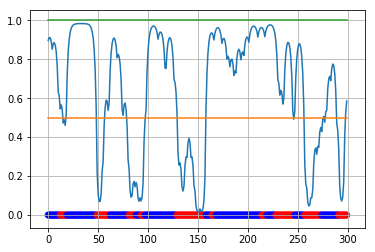

In [202]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)

ax.plot([.5 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


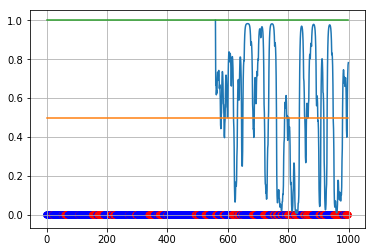

In [199]:
PosteriorHack = PosteriorDecodingScaled(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Отоброзилась только часть графика. Это связано с делением на ноль при вычисление conditionalProbability. Проверим:

In [200]:
[PosteriorHack.pathProbability*multiply(PosteriorHack.scaledConstF[i+1:]) for i in range(PosteriorHack.L)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

Действительно, некоторое количество членов действительно равны нулю из-за потери точности, даже при масштабирование.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


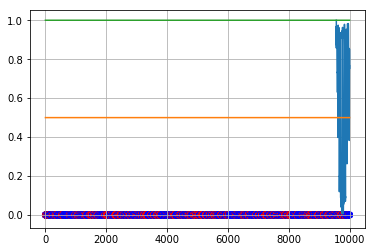

In [203]:
PosteriorHack = PosteriorDecodingScaled(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Тоже самое выходит и для 10 000 тысяч бросков. Возможно эту проблему можно решить сократив каким-то образом оставшиеся в числителе scalledConstB с scalledConstF в знаминателе.

## Алгоритм Баума-Велша

Реализуем класс с параметрами, которые не совпадают с параметрами используемой марковской цепи.

In [204]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.8,0.2]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 1/2,
            'U': 1/2
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [2/12,2/12,2/12,3/12,2/12,1/12],
            'U': [1/10,2/10,1/20,3/20,2/20,8/20]
        }

In [208]:
class BaumWelchTrainig(parametrs):
    def __init__(self, data):
        parametrs.__init__(self, data)

        # For forward
        self.f = []
        self.pathProbability = None
        # for backward
        self.b = []
        # For decoding
        self.conditionalProbability = None
        
        #self.epselon = 10**-100
        self.epselon = 1
        self.iterationNumber = 1000
        
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i, state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def stepBackward(self, index):
        self.b.append([])
        nextState = self.b[-2]
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
            
    def initializationForwardBack(self):
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        self.b.append([1,1])
        ### Backward part ###
        for i in range(self.L-1,0,-1): # С двойки?
            self.stepBackward(i)
        self.b = self.b[::-1]
    
    
    def __call__(self):
        if self.isFitted == False: self.initialization()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        #pprint.pprint('startProbability: {}'.format(self.startProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initialization(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            # Calculate f and b
            self.f = []
            self.pathProbability = 0
            self.b = []
            self.initializationForwardBack()
            # Change paramets
            self.changeParametrs()
            currentLog = self.logLikelihood()
            #print(currentLog)
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [209]:
trainig = BaumWelchTrainig(dataset300)
trainig()

Log doesnot change: stop in 5 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.3226459, 0.6773541]), 'U': "
 'array([0.17324779, 0.82675221])}')
("diceValueProbability: {'F': [0.00026068700109368575, 2.7860476604130274e-05, "
 '0.0020567195755569704, 0.5672830802048101, 0.43037093153560324, '
 "7.212063319211992e-07], 'U': [0.23420811229734761, 0.23430261274785305, "
 '0.23347913226476202, 0.004063064511720269, 0.05963345004777603, '
 '0.23431362813054082]}')


После тренировке на 300 бросках, алгоритм смог равномерно раскидать выпадающие значения на кубиках, а так же смог уловить общую тенденцию в переходах между кубиками, но не смог выделить нечестный кубик.

In [207]:
trainig = BaumWelchTrainig(dataset1000)
trainig()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log


Stop: max iterations
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([nan, nan]), 'U': array([nan, nan])}"
("diceValueProbability: {'F': [nan, nan, nan, nan, nan, nan], 'U': [nan, nan, "
 'nan, nan, nan, nan]}')


На 1000 бросках происходит накопление ошибки, что ведет к переполнению переменных. Возможным решением проблемы может служить дополнительная нормировка, но я не знаю как ее сделать.